In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/scratch/msc24h18/msc_project/aihwkit/src/')

plt.style.use('ggplot')

sys.path

['/scratch/msc24h18/msc_project/aihwkit/src',
 '/scratch/msc24h18/.conda/envs/aihwkit_dev/lib/python311.zip',
 '/scratch/msc24h18/.conda/envs/aihwkit_dev/lib/python3.11',
 '/scratch/msc24h18/.conda/envs/aihwkit_dev/lib/python3.11/lib-dynload',
 '',
 '/home/msc24h18/.local/lib/python3.11/site-packages',
 '/scratch/msc24h18/.conda/envs/aihwkit_dev/lib/python3.11/site-packages',
 '/scratch/msc24h18/msc_project/src',
 '/scratch/msc24h18/msc_project/aihwkit/src/']

In [3]:
WORKING_DIR = '/scratch/msc24h18/msc_project'
FILE_PATH = '/scratch/msc24h18/msc_project/data/LBE247_analyzed_2nd_run_only/LBE247_ID294YR/pulsedAmplitudeSweep_DCIV_20240919110921/pulsedAmplitudeSweep_DCIV[LBE247_ID294YR(3)]20240919111350/pulsedAmplitudeSweep_DCIV[LBE247_ID294YR(3)]20240919111350_Summary.dat'
#FILE_PATH = '/scratch/msc24h18/msc_project/data/LBE247_analyzed_2nd_run_only/LBE247_ID301XR1000Oct/pulsedAmplitudeSweep_DCIV_20240919141831/pulsedAmplitudeSweep_DCIV[LBE247_ID301XR1000Oct(1)]20240919142007/pulsedAmplitudeSweep_DCIV[LBE247_ID301XR1000Oct(1)]20240919142007_Summary.dat'
#FILE_PATH = '/scratch/msc24h18/msc_project/data/LBE247_analyzed_2nd_run_only/_ID161ZR15000/pulsedAmplitudeSweep_DCIV_20241024112252/pulsedAmplitudeSweep_DCIV[_ID161ZR15000(1)]20241024112607/pulsedAmplitudeSweep_DCIV[_ID161ZR15000(1)]20241024112607_Summary.dat'
#FILE_PATH = '/scratch/msc24h18/msc_project/data/LBE247_analyzed_2nd_run_only/_ID170ZR5000/pulsedAmplitudeSweep_DCIV_20241024131813/pulsedAmplitudeSweep_DCIV[_ID170ZR5000(1)]20241024132232/pulsedAmplitudeSweep_DCIV[_ID170ZR5000(1)]20241024132232_Summary.dat'

data = pd.read_csv(os.path.join(WORKING_DIR, FILE_PATH), skiprows=6)

data.head()

,Pulse Number,index,Pulse Amplitude (V),R_low (ohm),R_high (ohm)
0,1,4,0.4,7.071386e+07,7.956842e+07
1,2,5,0.5,7.145256e+07,8.052762e+07
2,3,6,0.6,7.233168e+07,8.168667e+07
3,4,7,0.7,7.388908e+07,8.359317e+07
4,5,8,0.8,7.607282e+07,8.611336e+07


Number of LTP pulses: 15
Number of LTD pulses: 27


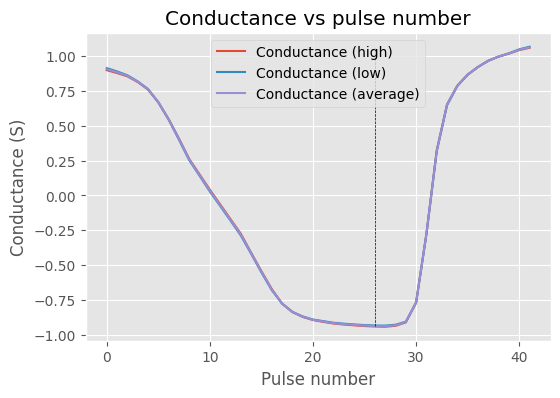

In [4]:
conductance_l = np.array(1 / data['R_high (ohm)'])
conductance_h = np.array(1 / data['R_low (ohm)'])
conductance = (conductance_l + conductance_h) / 2


def normalize(c):
    return 2 * (c - c.mean()) / (c.max() - c.min())


conductance_l = normalize(conductance_l)
conductance_h = normalize(conductance_h)
conductance = normalize(conductance)

# ltp pulses are expected to be positive for fitting to work
pulses = np.array([-1 if v > 0 else 1 for v in data['Pulse Amplitude (V)']])
conductance_ltp = conductance[np.where(pulses == 1)[0]]
conductance_ltd = conductance[np.where(pulses == -1)[0]]
pulse_change_idx = np.where(np.diff(pulses) != 0)[0]

print(f"Number of LTP pulses: {len(conductance_ltp)}")
print(f"Number of LTD pulses: {len(conductance_ltd)}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance_h, label='Conductance (high)')
ax.plot(conductance_l, label='Conductance (low)')
ax.plot(conductance, label='Conductance (average)')
ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number", ylabel="Conductance (S)", title="Conductance vs pulse number")
ax.legend()
plt.show()

In [5]:
from aihwkit.utils.fitting import fit_measurements


def fit_model(device_config, params=None):
    if params is None:
        params = {'dw_min': (0.1, 0.0001, 1.0),
            'up_down': (0.0, -0.99, 0.99),
            'w_max': (1.0, 0.1, 2.0),
            'w_min': (-1.0, -2.0, -0.1)
            }

    result, device_config_fit, best_model_fit = fit_measurements(
        params,
        pulses,
        conductance,
        device_config)

    print(device_config_fit)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(conductance, label='Measured')
    ax.plot(best_model_fit, label='Fit')
    ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
    ax.set(xlabel="Pulse number", ylabel="[Norm.] Conductance", title=str(device_config))
    ax.legend()
    plt.show()

    # return result, device_config_fit, best_model_fit

In [6]:
from aihwkit.simulator.configs import (
    ConstantStepDevice,
    ExpStepDevice,
    LinearStepDevice,
    PowStepDevice,
    SoftBoundsDevice
)

fit_model(ConstantStepDevice())

params = {'dw_min': (0.1, 0.0001, 1.0),
            'up_down': (0.0, -0.99, 0.99),
            'w_max': (1.0, 0.1, 2.0),
            'w_min': (-1.0, -2.0, -0.1),
            'gamma_up': (0.1, 0.000001, 1.0),
            'gamma_down': (0.1, 0.000001, 1.0)
            }
fit_model(LinearStepDevice(), params)

params = {'dw_min': (0.1, 0.0001, 1.0),
            'up_down': (0.0, -0.99, 0.99),
            'w_max': (1.0, 0.1, 2.0),
            'w_min': (-1.0, -2.0, -0.1),
            'gamma_up': (12.44625, 1, 20),
            'gamma_down': (12.78785, 1, 20),
            'A_up': (0.00081, 0.000001, 1),
            'A_down': (0.3683, 0.000001, 1),
            'a': (0.244, 0.001, 1.0),
            'b': (0.2425, 0.001, 1.0)
            }
fit_model(ExpStepDevice(), params)

params = {'dw_min': (0.1, 0.0001, 1.0),
            'up_down': (0.0, -0.99, 0.99),
            'w_max': (1.0, 0.1, 2.0),
            'w_min': (-1.0, -2.0, -0.1),
            'pow_gamma': (1.0, 0.0001, 10),
            }
fit_model(PowStepDevice(), params)
fit_model(SoftBoundsDevice())

RuntimeError: Error in rpu_pulsed_device.h:161  Sparse update with pulse counting not available for this device!

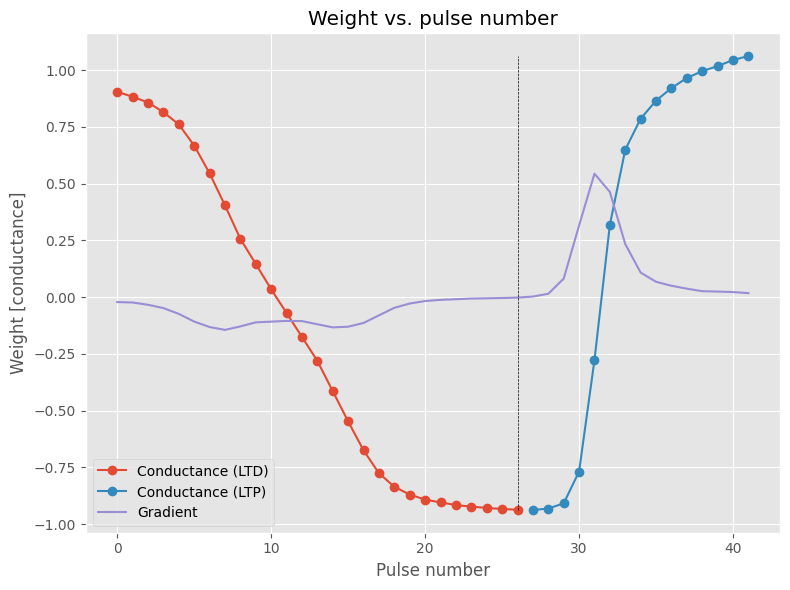

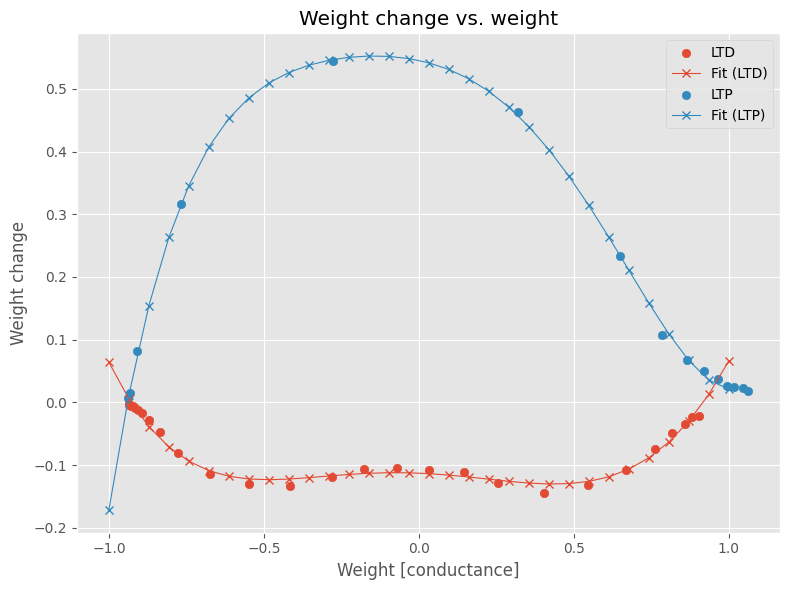

In [7]:
from numpy.polynomial.polynomial import Polynomial
pulses_ltp = np.where(pulses == 1)[0]
pulses_ltd = np.where(pulses == -1)[0]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(pulses_ltd, conductance_ltd, label='Conductance (LTD)', marker='o')
ax.plot(pulses_ltp, conductance_ltp, label='Conductance (LTP)', marker='o')
# ax.plot(conductance)
ax.plot(np.gradient(conductance), label='Gradient')
ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number", ylabel="Weight [conductance]", title="Weight vs. pulse number")
ax.legend()
plt.tight_layout()
#plt.savefig('tmp1.png')
plt.show()

grad_ltd = np.gradient(conductance_ltd)
grad_ltp = np.gradient(conductance_ltp)

fit_degree = 5
fit_grad_ltd = Polynomial.fit(conductance_ltd, grad_ltd, fit_degree)
fit_grad_ltp = Polynomial.fit(conductance_ltp, grad_ltp, fit_degree)

#xvals = np.linspace(conductance.min(), conductance.max(), 100)
xvals = np.linspace(-1, 1, 32)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(conductance_ltd, grad_ltd, label='LTD', color='C0')
ax.plot(xvals, fit_grad_ltd(xvals), label='Fit (LTD)', color='C0', lw=0.8, marker='x')

ax.scatter(conductance_ltp, grad_ltp, label='LTP', color='C1')
ax.plot(xvals, fit_grad_ltp(xvals), label='Fit (LTP)', color='C1', lw=0.8, marker='x')

ax.set(xlabel="Weight [conductance]", ylabel="Weight change", title="Weight change vs. weight")
ax.legend()
plt.tight_layout()
# plt.savefig('tmp2.png')
plt.show()

PiecewiseStepDevice(
    dw_min=0.005623916337487364,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=-0.27474532028895826,
    up_down_dtod=0.0,
    w_max=1.0083578809737224,
    w_max_dtod=0.0,
    w_min=-1.0001982682654431,
    w_min_dtod=0.0,
    piecewise_up=[
        30.528114580230216,
        2.0544992740630126,
        27.375238496436026,
        46.79310919801045,
        61.480367179882,
        72.43527966257909,
        80.49488701552181,
        86.34776448648061,
        90.54678393103534,
        93.52187554203394,
        95.59278957905138,
        96.98185809784844,
        97.82675667983057,
        98.19326616150676,
        98.08803436394834,
        97.47133782224786,
        96.2698435149779,
        94.38937059364994,
        91.72765211217319,
        88.18709675631345,
        83.6875505731519,
        78.17905870054402,
        71.65462709657832,
        64.1629842690354,
        55.821343004846504,
        46.82816209955258,
        3

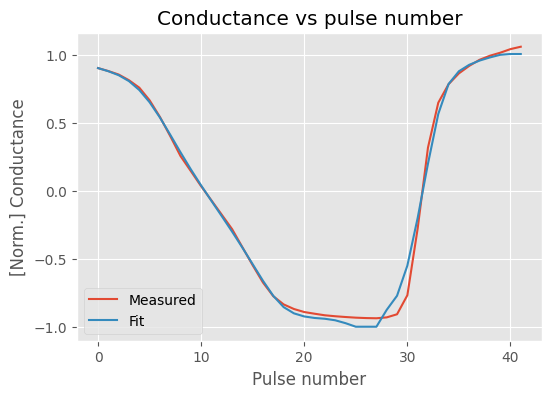

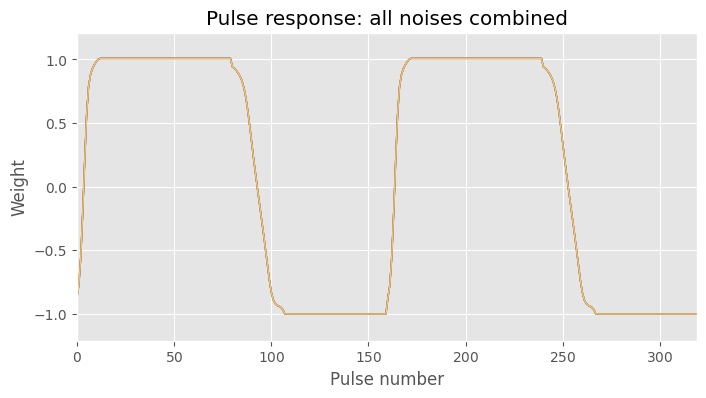

In [8]:
from aihwkit.utils.visualization import get_tile_for_plotting, compute_pulse_response
from aihwkit.simulator.configs import build_config
from aihwkit.utils.fitting import fit_measurements
from aihwkit.simulator.configs import PiecewiseStepDevice
from aihwkit.utils.visualization import plot_device_compact

condvals = np.linspace(-1, 1, 32)
fit_ltp_vals = np.abs(fit_grad_ltp(condvals))
fit_ltd_vals = np.abs(fit_grad_ltd(condvals))

dw_min_up = fit_ltp_vals.min()
dw_min_down = fit_ltd_vals.min()
dw_min = min(fit_ltp_vals.min(), fit_ltd_vals.min())
fit_ltp_vals /= dw_min
fit_ltd_vals /= dw_min

params = {'dw_min': dw_min,
          'up_down': (0.0, -0.99, 0.99),
          'w_max': (1.0, 0.1, 2.0),
          'w_min': (-1.0, -2.0, -0.1),
          }

result, pw_device_fit, pw_device_response = fit_measurements(
    params,
    pulses,
    conductance,
    PiecewiseStepDevice(
        piecewise_up=list(fit_ltp_vals),
        piecewise_down=list(fit_ltd_vals)
    ))

# rescale dw_min and conductance gradient
#pw_device_fit.dw_min = dw_min
#pw_device_fit.piecewise_up = list(fit_ltp_vals / dw_min_up)
#pw_device_fit.piecewise_down = list(fit_ltd_vals / dw_min_down)


#scale = (np.mean(fit_ltp_vals) + np.mean(fit_ltd_vals)) / 2
#pw_device_fit.dw_min *= scale
#pw_device_fit.piecewise_up = list(fit_ltp_vals / scale)
#pw_device_fit.piecewise_down = list(fit_ltd_vals / scale)

print(pw_device_fit)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance, label='Measured')
ax.plot(pw_device_response, label='Fit')
ax.set(xlabel="Pulse number", ylabel="[Norm.] Conductance", title="Conductance vs pulse number")
ax.legend()
plt.show()

pw_device_fit.dw_min_dtod = 0#0.3
pw_device_fit.dw_min_std = 0#0.3
pw_device_fit.w_min_dtod = 0#0.3
pw_device_fit.w_max_dtod = 0#0.3
pw_device_fit.write_noise_std = 0#0.3
pw_device_fit.up_down_dtod = 0

rpu_config = build_config('sgd', pw_device_fit)

fig, ax = plt.subplots(figsize=(8, 4))
ax = plot_device_compact(pw_device_fit, n_steps=80, n_traces=5, n_loops=2, axes=ax);
ax.set(xlabel="Pulse number", ylabel="Weight", title="Pulse response: all noises combined")

plt.savefig('tmp.png')
plt.show()

RuntimeError: Error in rpu_pulsed_device.h:161  Sparse update with pulse counting not available for this device!

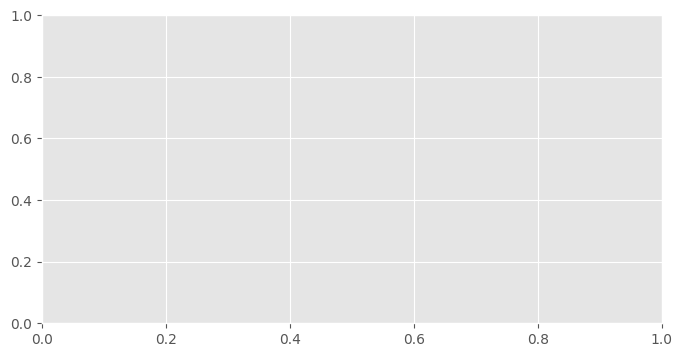

In [9]:
from aihwkit.simulator.configs.compounds import OneSidedUnitCell

pw_device_fit.dw_min_dtod = 0#0.3
pw_device_fit.dw_min_std = 0#0.3
pw_device_fit.w_min_dtod = 0#0.3
pw_device_fit.w_max_dtod = 0#0.3
pw_device_fit.write_noise_std = 0#0.3
pw_device_fit.up_down_dtod = 0

rpu_config = build_config('sgd', pw_device_fit)

fig, ax = plt.subplots(figsize=(8, 4))
ax = plot_device_compact(OneSidedUnitCell([pw_device_fit]), n_steps=80, n_traces=5, n_loops=2, axes=ax);
ax.set(xlabel="Pulse number", ylabel="Weight", title="Pulse response: all noises combined")

plt.savefig('tmp.png')
plt.show()